# Country visualization test

## Summary
This notebook is a prototype to visualize countries shapes as polygons and to overlay them with point data. The dummy point data in this case is the Naturalearth dataset for populated places. Many countries prove problematic for visualization, because they consist of several parts, sometimes far apart (e.g. overseas territories). In this notebook, an algorithm of distance based grouping is implemented, which allows to create a main plot of the countries most prominent polygons followed by several subplots with grouped area.

#### Installation
1. Create virtual environment from requirements.txt
2. Add kernel to jupyter notebook using *ipython kernel install --user --name=YOUR_VIRTUAL_ENV_NAME*

In [1]:
# Hidden depedency of geopandas: descartes
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
country_name = 'France'

## Preprocess Datasets
Datasets are from [naturalearthdata](https://www.naturalearthdata.com/downloads/10m-cultural-vectors/) with public license, meaning they are free to use for everybody. For countries the dataset **Admin 0 – Countries** is used, for the populated places, the dataset **Populated Places** is used.

In [3]:
# Read countries and populated places from shapefile
all_countries = gpd.read_file('data/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp')
pop_places = gpd.read_file('data/ne_10m_populated_places/ne_10m_populated_places.shp')

In [4]:
# Select country and project to pseudo mercator
country_4326 = all_countries[all_countries['ADMIN'] == country_name].copy()
country_3857 = country_4326.to_crs(epsg=3857)

In [5]:
# Select populated places within country_name and project to pseudo mercator
data_4326 = pop_places[(pop_places['ADM0NAME']==country_name)].sort_values(by=['POP_MAX'], ascending=False)
data_3857 = data_4326.to_crs(epsg=3857)

## Algorithm
### Goal
Given a country and a georeferenced point dataset (ordered by some column X, i.e. hazard risk), plot overlay points with country.

### Challenge
Many countries consist of a large main polygon (called primary hereafter) as well as multiple other polygons of various sizes (called secondaries hereafter), which can be 
- ... very close to the primary with an example being China. In this case we want to plot them all together in the main plot.
- ... far away from the primary with an exampl being France or Portugal with their oversea territories. In this case we might want to create subplot displaying them not according to their true distance and size.
- ... a combination of both above.

### Idea
- We can use spatial operations like buffering and bounding boxes to find secondaries close enough to primaries to be displayed in the main plot. This process can be repeated to create groups of distance related polygon groups.
- In a next step, only groups containing point data are of interest.
- If the number of secondaries from step 2 is large, the ones with the highest column value X should be given priority. (Not implemented here)

### Pseudo Algorithm
Start with GeoDataFrame containing a Multipolygon, then do:
0. Create a new GeoDataFrame with one row for each polygon. Geometry type is POLYGON.
1. Get primary.
2. Create a buffer around primary.
3. Select all secondaries within buffer and dissolve to new primary.
4. Select all remaining secondaries.
5. Go back to step 1 using the remaining secondaries. Repeat until no secondaries remain.
6. Find which polygons contain point data. Create geoseries for plotting.
7. Initialize plots.

## Algorithm Implementation

In [6]:
# Parameter
dissolve_buffer_m = 500000
# 0. Split Multipolygon into single Polygons.
country_gdf = gpd.GeoDataFrame({'geometry': list(*country_3857.geometry)}, crs=country_3857.crs)

remaining_gdf = country_gdf.copy()
# Store actual geometries in geometry_groups
geometry_groups = []
# Use geoseries for plotting
geoseries = []
while remaining_gdf.shape[0] > 0:
    # 1. Get primary
    primary = remaining_gdf[remaining_gdf.area == remaining_gdf.area.max()]
    # 2. Create a buffer around primary.
    primary_buffered_bbox = primary.buffer(distance=dissolve_buffer_m).envelope.iloc[0]
    # 3. Select all secondaries within buffer and dissolve to new primary.
    within_primary_bool = country_gdf.centroid.within(primary_buffered_bbox)
    new_primary = remaining_gdf.loc[within_primary_bool].unary_union
    geometry_groups.append(new_primary)
    geoseries.append(gpd.GeoSeries(new_primary))
    # 4. Select all remaining secondaries containing a data.
    remaining_gdf = remaining_gdf.loc[within_primary_bool == False]
    dissolve_buffer_m = dissolve_buffer_m / 2
    # 5. Go back to step 1 using the remaining secondaries. Repeat until no secondaries remain.

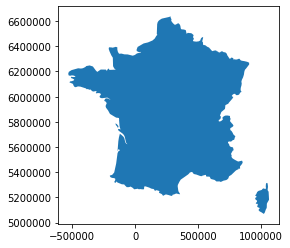

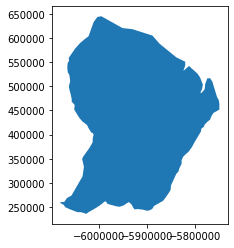

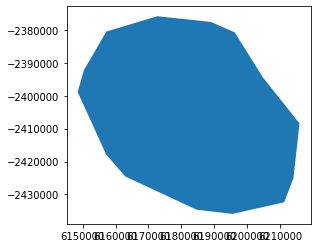

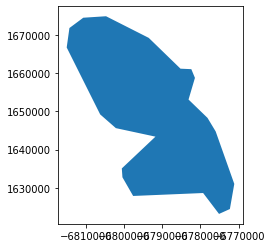

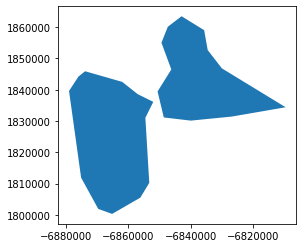

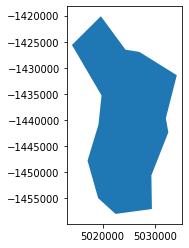

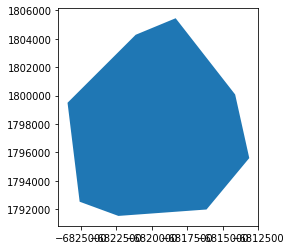

In [7]:
# Show all grouped polygons
for geoserie in geoseries:
    geoserie.plot()

In [8]:
# 6. Find which polygons contain point data. Create geoseries for plotting.
geometry_geoseries = []
data = []
for geom in geometry_groups:
    data_within_geom = data_3857.geometry.within(geom)
    if sum(data_within_geom) > 0:
        data.append(data_3857[data_within_geom])
        geometry_geoseries.append(gpd.GeoSeries(geom))
country_primary, country_secondaries = geometry_geoseries[0], geometry_geoseries[1:]
data_primary, data_secondaries = data[0], data[1:]

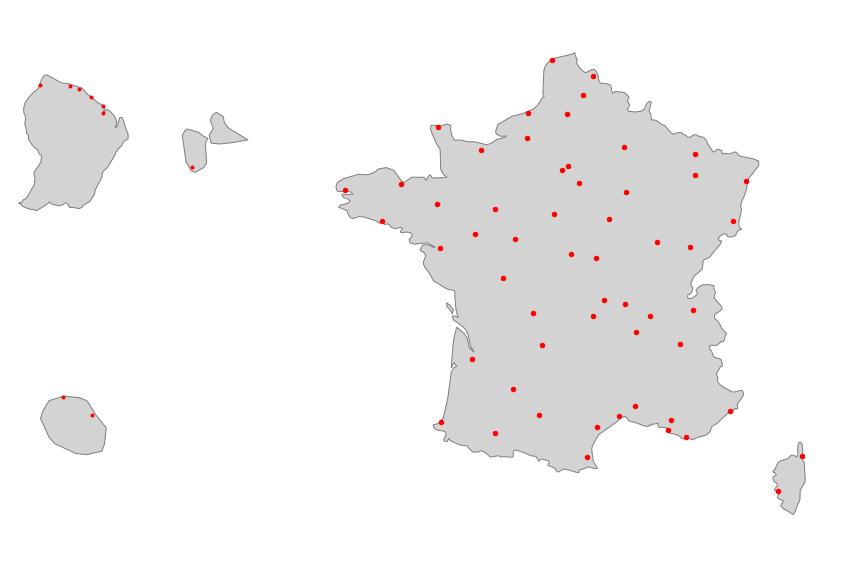

In [9]:
# 7. Initialize plot.

# This number defines the ratio of the primary plots width to the secondary plot widths
ratio_primary_secondaries = 2
# Figure dimensions
fig = plt.figure(figsize=(12, 8))

# If secondaries exist:
if country_secondaries:
    import math
    n_rows = math.ceil(math.sqrt(len(country_secondaries)))
    n_cols = math.ceil(len(country_secondaries) / n_rows)

    # Plot primary
    ax = plt.subplot2grid((n_rows, (ratio_primary_secondaries+1)*n_cols), (0, n_cols), colspan=ratio_primary_secondaries*n_cols, rowspan=n_rows)
    ax.set_title('')
    country_primary.plot(ax=ax, facecolor='lightgray', edgecolor='gray')
    data_primary.plot(ax=ax, facecolor='red', markersize=20)
    ax.set_axis_off()
    plt.margins(0.1)
    plt.axis('equal');

    # Plot secondaries
    for i in range(len(country_secondaries)):
        col = math.floor(i/n_cols)
        row = i%n_rows
        ax = plt.subplot2grid((n_rows, (ratio_primary_secondaries+1)*n_rows), (row, col), colspan=1, rowspan=1)
        country_secondaries[i].plot(ax=ax, facecolor='lightgray', edgecolor='gray')
        data_secondaries[i].plot(ax=ax, facecolor='red', markersize=9)
        plt.margins(0.5)
        plt.axis('equal');
        ax.set_axis_off()
    plt.tight_layout()
else:
    ax = fig.add_subplot(111)
    country_primary.plot(ax=ax, facecolor='lightgray', edgecolor='gray')
    data_primary.plot(ax=ax, facecolor='red', markersize=20)
    ax.set_axis_off()
    plt.axis('equal');